In [1]:
import pandas as pd
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (16, 9)

# 1 задание

In [2]:
df = pd.read_csv('./файл 1.txt', sep='\t')
df.head()

,login,tid,Microtasks,assigned_ts,closed_ts
0,login0,190563850.0,4.0,2017-04-20 12:09:39,2017-04-20 13:13:01
1,login0,190561754.0,1.0,2017-04-20 12:10:30,2017-04-20 12:28:29
2,login0,190565906.0,4.0,2017-04-20 12:21:31,2017-04-20 13:30:10
3,login0,190560246.0,1.0,2017-04-20 12:28:30,2017-04-20 13:13:56
4,login0,190562168.0,2.0,2017-04-20 12:28:42,2017-04-20 13:14:50


In [3]:
df.shape

(701827, 5)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 701827 entries, 0 to 701826
Data columns (total 5 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   login        701827 non-null  object 
 1   tid          701827 non-null  float64
 2   Microtasks   701827 non-null  float64
 3   assigned_ts  701827 non-null  object 
 4   closed_ts    701827 non-null  object 
dtypes: float64(2), object(3)
memory usage: 26.8+ MB


In [5]:
# даты считались как строки, преобразуем их в timestamp, чтобы было проще работать
df['assigned_ts'] = pd.to_datetime(df['assigned_ts'])
df['closed_ts'] = pd.to_datetime(df['closed_ts'])

Рассчитаем затраченное время на одно микрозадание для каждого задания и посмотрим на описательные статистики.

$timespent = \frac{ts_{closed} - ts_{assigned}}{microtasks}$ 

In [6]:
df['time_spent'] = (df['closed_ts'] - df['assigned_ts']) / df['Microtasks'] 

In [7]:
df['time_spent'].describe()

count                       701827
mean     0 days 00:09:28.151539205
std      0 days 01:29:38.995442629
min              -1 days +23:47:51
25%                0 days 00:00:37
50%                0 days 00:01:15
75%                0 days 00:03:02
max               12 days 10:22:36
Name: time_spent, dtype: object

Можно заметить, что в данных имеются выбросы: минимум затраченного почти -2 суток, т.е. задание сделано раньше, чем было получено - ошибка в данных (ну или добавили задание задним числом); максимум 12 дней тоже скорее всего является ошибкой в данных (либо не очень эффективный ассессор). 
    
Судя по квантилям, задания выполняются довольно быстро в среднем, поэтому установим верхнюю границу отсечения 1 час. Если за 1 час задание все еще не выполнено, его можно переназначить другому ассессору. С учетом того, что таких случаев всего около 3%, больших издержек это принести не должно.

In [8]:
share_more_than_hour = (df['time_spent'] > pd.Timedelta(hours=1)).sum() / df.shape[0]
print(f'Доля микрозаданий с затраченным временем > 1 часа: {share_more_than_hour:.2f}')

Доля микрозаданий с затраченным временем > 1 часа: 0.03


In [9]:
spent_more_0 = df['time_spent'] > pd.Timedelta(0)
spent_less_1hour = df['time_spent'] < pd.Timedelta(hours=1)

df = df[spent_more_0 & spent_less_1hour]

In [10]:
df['time_spent'].describe()

count                       682090
mean     0 days 00:03:18.820066485
std      0 days 00:06:44.475111536
min      0 days 00:00:01.769230769
25%                0 days 00:00:36
50%                0 days 00:01:12
75%                0 days 00:02:44
max      0 days 00:59:59.555555555
Name: time_spent, dtype: object

После очистки данных от выбросов, статистики стали выглядеть более адекватно. Посмотрим на распределение получившейся величины. 

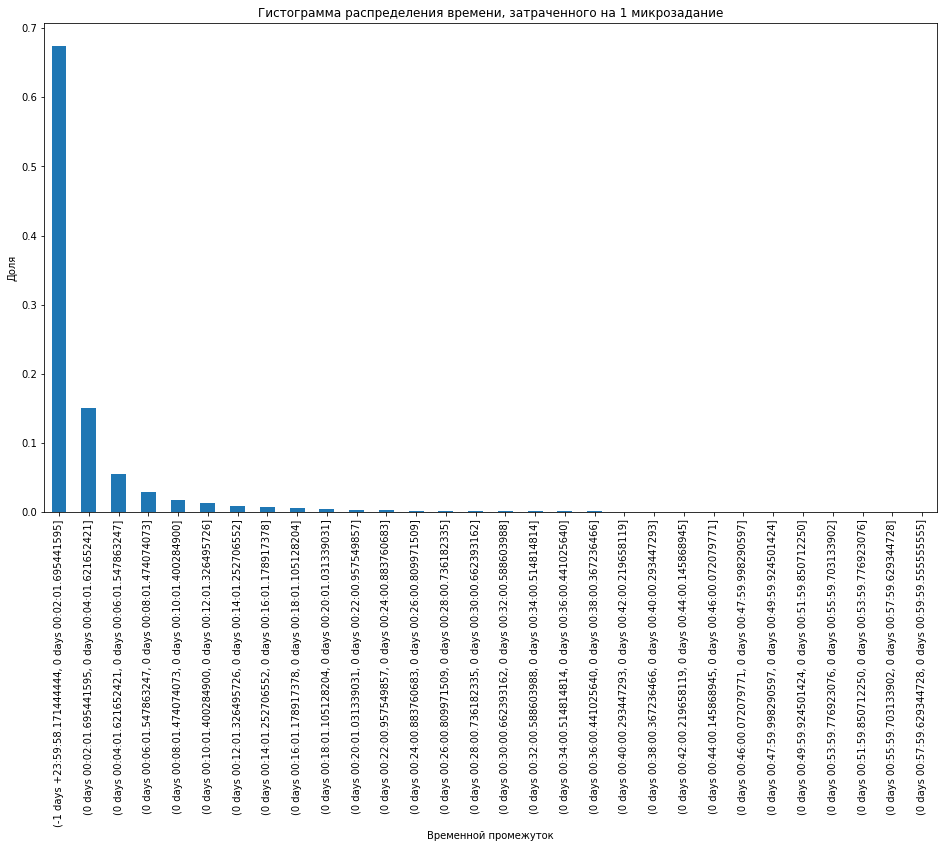

In [11]:
pd.cut(df['time_spent'], bins=30, include_lowest=True).value_counts(normalize=True).plot.bar()

plt.title('Гистограмма распределения времени, затраченного на 1 микрозадание')
plt.ylabel('Доля')
plt.xlabel('Временной промежуток');

Видно, что получившееся распределение не является нормальным, оно ближе к экспоненциальному, при этом почти 70% заданий выполняется менее чем за 2 минуты, после чего идет резкое падение доли. При этом на почти 90% заданий уходит не более 6 минут, остальные случаи скорее всего относятся к тем ситуациям, когда ассессор отошел попить чаю. Однако выполнение заданий в промежутке от 2 до 6 минут может быть обусловлено ситуацией, когда ассессору назначено задание до того, как он закончил предыдущее, поэтому адекватным временем, затраченным на микрозадание будем считать 2 минуты. Соответственно, оплата за 1 микрозадание должна быть равна 120 секунд / 30 секунд * N = 4 * N.

**Ответ:** 4 * N

# 2 задание

In [31]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

In [13]:
df = pd.read_csv('./файл 2.csv', sep='\t')
df.head()

,login,uid,docid,jud,cjud
0,assessor158,158,0,0,0
1,assessor238,238,0,0,0
2,assessor488,488,0,0,0
3,assessor136,136,0,0,0
4,assessor300,300,0,0,0


In [17]:
df.shape

(250000, 5)

In [27]:
print(f'Всего {df["login"].nunique()} ассессоров')

Всего 600 ассессоров


Можно рассматривать ассессоров как бинарные классификаторы, тогда для оценки качества их работы можно применить стандартные метрики оценки качества классификации: accuracy, precision, recall, f1-score.

Для начала посмотрим на соотношение классов в выборке, при этом удостоверившись, что каждый документ имеет одинаковое количество оценок.

In [78]:
print(f'Всего {df["docid"].nunique()} документов')

how_many_docs_marks = df.groupby('docid')['docid'].count()
if how_many_docs_marks.nunique() == 1:
    print(f'Каждый документ имеет {how_many_docs_marks.iloc[0]} оценок')
else:
    print('Каждый документ имеет разное количество оценок')

Всего 50000 документов
Каждый документ имеет 5 оценок


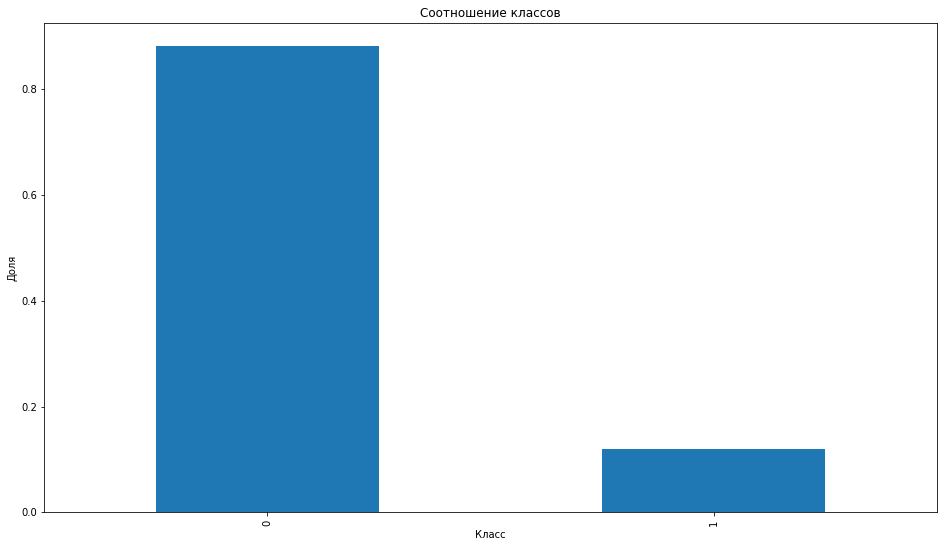

In [77]:
df['cjud'].value_counts(normalize=True).plot.bar()

plt.title('Соотношение классов')
plt.xlabel('Класс')
plt.ylabel('Доля');

Видно, что документов класса 0 сильно больше, чем документов класса 1, поэтому можем сразу отбросить accuracy как метрику для оценки качества классификатора, поскольку accuracy больше 0.8 можно получить простым константным классификатором, предсказывающим 0 для любого документа.

Такого недостатка лишены precision и recall, однако для корректного выбора из этих 2 метрик необходимо знать конкретную бизнес-задачу для того, чтобы определить, хотим ли мы минимизировать вероятность ошибки 1 рода (тогда берем precision) или вероятность ошибки 2 рода (тогда берем recall). Поэтому возьмем f1-score как метрику, балансирующую precision и recall с $\beta = 1$, т.е. по сути среднее гармоническое между precision и recall.

count    600.000000
mean       0.562748
std        0.099385
min        0.103896
25%        0.500000
50%        0.557735
75%        0.641580
max        0.751773
dtype: float64


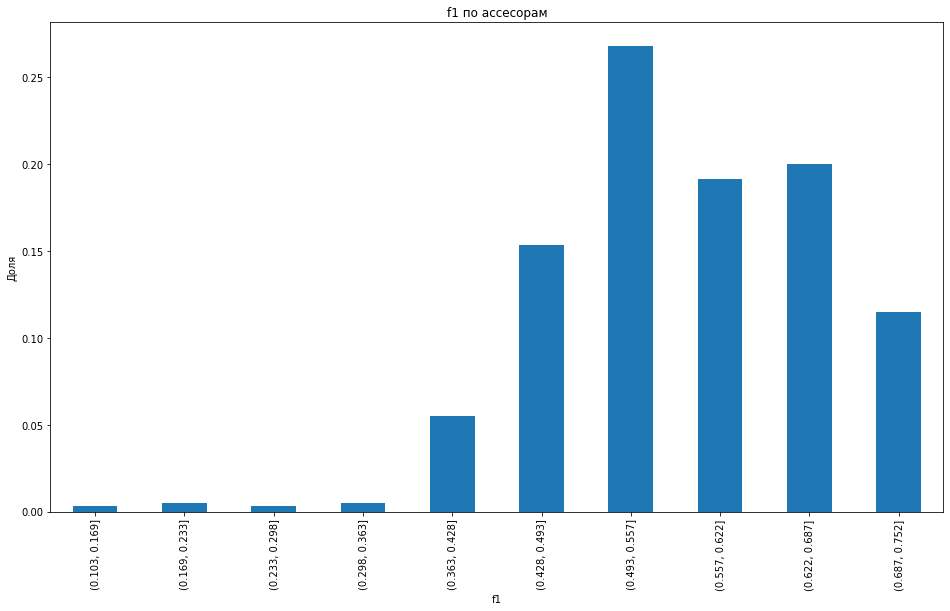

In [80]:
assessors_f1 = df.groupby('login')[['jud', 'cjud']].apply(lambda marks: f1_score(marks['cjud'], marks['jud']))
print(assessors_f1.describe())

pd.cut(assessors_f1, bins=10).value_counts(normalize=True).sort_index().plot.bar()
plt.title('f1 по ассесорам')
plt.xlabel('f1')
plt.ylabel('Доля');

Из гистограммы распределения видно, что распределение в целом получилось довольно сбалансированным (медиана и среднее очень близки), однако имеется ярко выраженный левый хвост, именно в этом хвосте находятся ассесоры, справившиеся с задачей хуже всего. Таким образом, берем границу отсечения $0.363$.

In [90]:
worst_assessors = assessors_f1[assessors_f1 <= 0.363]
worst_assessors.sort_values(ascending=True)

login
assessor163    0.103896
assessor56     0.163121
assessor3      0.178571
assessor118    0.189723
assessor390    0.207407
assessor234    0.238806
assessor111    0.283186
assessor354    0.333333
assessor335    0.341463
assessor460    0.347826
dtype: float64

В целом данная задача вполне неплохо должна решаться с использованием классических метрик оценки качества классификации, при этом можно добалансировать решение за счет изменение $\beta$ для подсчета f1-score

Однако можно дополнительно учесть сложность классификации конкретного документа. В таком случае документ, на котором ошибается большое количество ассессоров, должен входить с большим весом в расчет метрики качества. За счет этого качество работы ассессора будет больше зависеть от "сложных" случаев, а правильная разметка слишком очевидных документов не даст ему большого прироста качества. 